In [1]:
import re

import pandas as pd

from processor.filters import cut_by_window
from utils import load_df_with_time_index
import matplotlib.pyplot as plt
from typing import Callable
import pickle as pkl
import seaborn as sns

In [2]:
def extract_fields(meta):
    match = re.search(r'{__name__="([^"]+)", group="::([^"]+)", scenario="([^"]+)"}', meta)
    if match:
        return match.group(1), match.group(2), match.group(3)
    return None, None, None


def get_os_and_processor(name: str) -> tuple[str, str]:
    os = "Windows" if "perfw" in name.lower() else "Linux"
    processor = "AMD" if "amd" in name.lower() else "Intel"
    return os, processor

In [3]:
def merge_dashboards(stored_data: dict[str, dict], dashboard_name: str, loader: Callable[[str], pd.DataFrame]):
    dfs = []
    for data in stored_data.values():
        vus = data["vus"]
        test_instance, identifier = data["instance_identifier"]
        dashboards = data["dashboards"]
        df = loader(dashboards[dashboard_name])
        df = df.melt(var_name='meta', value_name='value', ignore_index=False)
        df[['count_name', 'group', 'scenario']] = df['meta'].apply(lambda x: pd.Series(extract_fields(x)))
        df["vus"] = vus
        df["instance"] = "{} {}".format(*get_os_and_processor(test_instance))
        df["identifier"] = identifier
        df["os"], df["processor"] = get_os_and_processor(test_instance)
        # Apply extract_fields to the 'meta' column
        dfs.append(df)

    merged = pd.concat(dfs)
    merged = merged.sort_index()
    merged = merged.reset_index().set_index("Time")

    return merged

In [4]:
data_ = pkl.load(open("results/quick_data.pkl", "rb"))

In [5]:
group_duration = merge_dashboards(data_, "Group Duration", load_df_with_time_index)

In [6]:
group_duration[group_duration["instance"] == "Windows AMD"].index.max()

Timedelta('0 days 01:09:30')

In [7]:
cut_by_window(group_duration[group_duration['scenario'] == 'SalesOrderEntry'], "20m","40m")["instance"].unique()

array(['Windows AMD', 'Linux AMD'], dtype=object)

In [8]:
sales_order_entry = group_duration[group_duration['scenario'] == 'SalesOrderEntry']
sales_order_entry.loc[:,"group"] = sales_order_entry["group"].apply(lambda x: x.split("_")[-1])
sales_order_entry = sales_order_entry[["value","group","scenario","instance"]]

In [9]:
sales_order_entry["group"].unique()

array(['GetNewOrderHed', 'GetNewOrderDtl', 'GetList', 'GetByID',
       'CheckForFirmJob', 'ChangeSellingQtyMaster', 'ChangeRequestDate',
       'ChangePartNumMaster', 'ChangeOrderHedCustomerCustID',
       'GetNewParameters', 'SetPrintInventoryAttributes', 'XbSysts',
       'MasterUpdate'], dtype=object)

In [10]:
group_duration["group"].unique()

array(['BAQDesigner', 'PartTracker_GlbPartsExist',
       'PartTracker_GetRowsPerPlantKinetic',
       'MiscARInvoice_OnChangeofLineQty', 'PartTracker_GetPartXRefInfo',
       'PartTracker_GetPartUOMPlasticTax',
       'MiscARInvoice_OnChangeofSoldToCustID',
       'PartTracker_GetListAndOrderAllocationGetRows',
       'PartTracker_GetFullBinSearch', 'MiscARInvoice_PrePostInvoices',
       'PartTracker_GetByID', 'PartMaintenance_Update',
       'MiscARInvoice_PrePrintInvoices',
       'PartMaintenance_PartUOMPlasticTaxUpdate',
       'PartMaintenance_InitializeTracker', 'MiscARInvoice_PreUpdate',
       'PartMaintenance_GlbPartsExist', 'PartMaintenance_GetRows',
       'PartMaintenance_GetPartXRefInfo',
       'MiscARInvoice_SetReadyToCalcEx',
       'MiscARInvoice_OnChangeofLinePartNum',
       'PartMaintenance_GetPartUOMPlasticTax',
       'PartTracker_ImageSvc_GetRows', 'MiscARInvoice_GetRowsNoLock',
       'QuoteEntry_GetNewQuoteHed', 'MiscARInvoice_GetNewInvcDtl',
       'QuoteEnt

In [11]:
sales_order_entry = sales_order_entry[sales_order_entry['group'].isin(['GetNewOrderHed','MasterUpdate','GetByID'])]
sales_order_entry['value'] = pd.to_numeric(sales_order_entry['value'], errors='coerce')
sales_order_entry = cut_by_window(sales_order_entry, "20m","40m")

In [12]:
sales_order_entry.describe()

,value
count,966.000000
mean,2.935890
std,0.555722
min,2.230000
25%,2.340000
50%,2.850000
75%,3.440000
max,3.920000


In [13]:
def plot_over_time(df: pd.DataFrame, y_col: str, title: str, ylabel: str, grouper: str = "instance",
                   ax: plt.Axes | None = None):

    instances = df[grouper].unique()
    palette = dict(zip(instances, sns.color_palette("tab10", len(instances))))
    if ax is None:
        fig, ax = plt.subplots(figsize=(7.5, 5))
    for name, group in df.groupby(grouper):
        color = palette.get(name)
        group.plot(use_index=True, y=y_col, label=name, ax=ax, color=color)
    plt.title(title)
    plt.ylabel(ylabel)
    if ax is None:
        plt.show()

In [14]:
sales_order_entry["instance"].unique()

array(['Linux AMD', 'Windows AMD'], dtype=object)

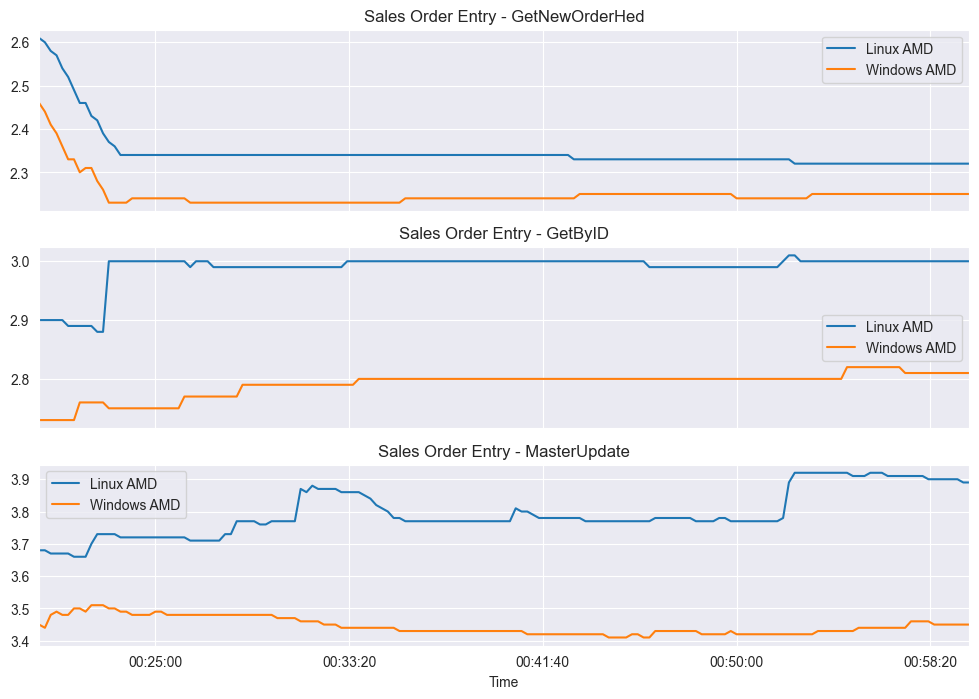

In [21]:
fig, axs = plt.subplots(3, 1, figsize=(12, 8))
for i,group in enumerate(sales_order_entry['group'].unique()):
    ax = axs[i]
    to_plot = sales_order_entry[sales_order_entry['group'] == group]
    for instance, instance_data in to_plot.groupby('instance'):
        instance_data.plot(use_index=True, y='value', label=instance, ax=ax)
    # to_plot.plot(use_index=True, y='value', label=group, ax=ax)
    ax.set_title(f'Sales Order Entry - {group}')
    if i < len(axs) - 1:
        ax.tick_params(labelbottom=False)
        ax.set_xlabel('')

    # plot_over_time(sales_order_entry[sales_order_entry['group'] == group], 'value', f'Sales Order Entry - {group}', 'Duration (ms)', ax=ax)

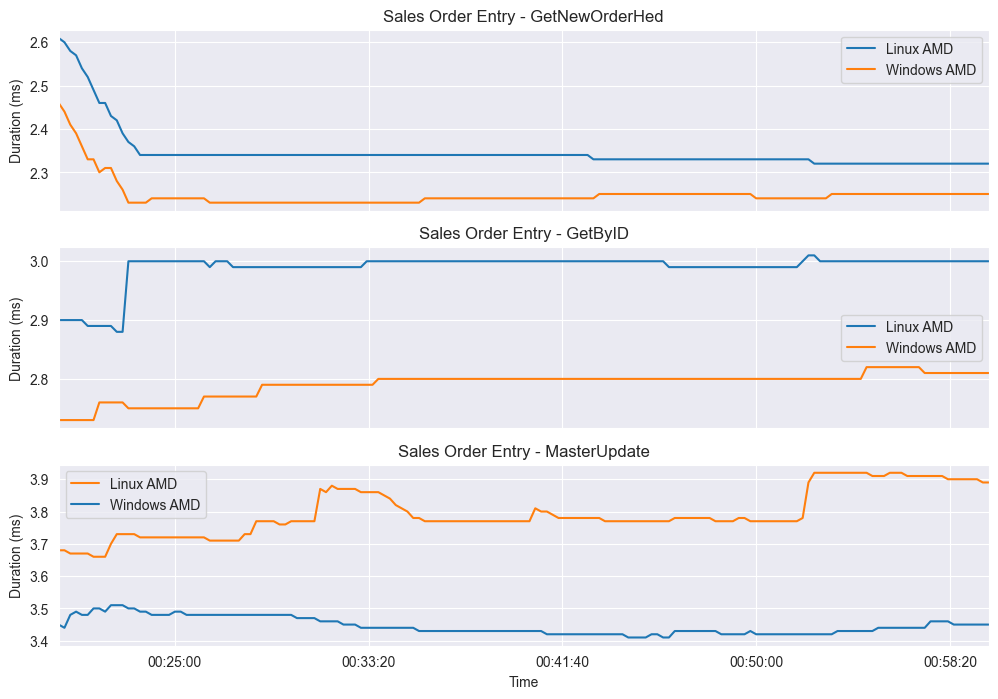

In [25]:
fig, axs = plt.subplots(3, 1, figsize=(12, 8))
for i,group in enumerate(sales_order_entry['group'].unique()):
    ax = axs[i]
    to_plot = sales_order_entry[sales_order_entry['group'] == group]
    plot_over_time(to_plot, 'value', f'Sales Order Entry - {group}', 'Duration (ms)', ax=ax)
    ax.set_title(f'Sales Order Entry - {group}')
    ax.set_ylabel('Duration (ms)')
    if i < len(axs) - 1:
        ax.tick_params(labelbottom=False)
        ax.set_xlabel('')

In [16]:
sales_order_entry.info()

<class 'pandas.core.frame.DataFrame'>
TimedeltaIndex: 966 entries, 0 days 00:20:00 to 0 days 01:00:00
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   value     966 non-null    float64
 1   group     966 non-null    object 
 2   scenario  966 non-null    object 
 3   instance  966 non-null    object 
dtypes: float64(1), object(3)
memory usage: 37.7+ KB


In [17]:
group_duration[group_duration['scenario'] == 'ARInvoiceTracker'].groupby('group').agg({'value': 'mean'}).sort_values(by='value', ascending=False).head(10)

,value
group,
GLJrnDtlSvc_GetRows,8.732105
GetRows,8.409583
GetByID,2.879673


In [18]:
query_calls = load_df_with_time_index("quick/perfwamd2_2025-08-21_13-30-00-Panel Title.csv")
query_calls  = query_calls.melt(var_name='meta', value_name='group_duration', ignore_index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'quick/perfwamd2_2025-08-21_13-30-00-Panel Title.csv'

In [ ]:
query_calls[['count_name', 'group', 'scenario']] = query_calls['meta'].apply(lambda x: pd.Series(extract_fields(x)))

In [ ]:
query_calls.drop(columns=['meta', 'count_name'], inplace=True)

In [ ]:
total_time = query_calls.index.max() - query_calls.index.min()
total_time = total_time.total_seconds() * 1000
print(f'Total time: {total_time}')

In [ ]:
query_calls[query_calls['scenario'] == 'ARInvoiceTracker'].groupby('group').agg({'group_duration': 'mean'}).sort_values(by='group_duration', ascending=False).head(10)

In [ ]:
def grafana_rate(group):
    # Your custom aggregation logic here
    # Example: calculate per-second rate for each group
    count = group['group_duration'].astype(float)
    time_diff = group.index.to_series().diff().dt.total_seconds()
    count_diff = count.diff()
    rate = count_diff / time_diff
    return pd.Series(rate, index=group.index, name='rate_grafana')

# Apply per group and add result as a new column
# query_calls.groupby('group').apply(grafana_rate)
#query_calls.groupby('group').apply(grafana_rate, include_groups=False)
query_calls.groupby('group').apply(grafana_rate, include_groups=False).reset_index(level=0).groupby('group').agg({'rate_grafana': 'mean'}).sort_values(by='rate_grafana', ascending=False).head(10) * 1000 # Convert to milliseconds

In [ ]:
query_calls[query_calls['scenario'] == 'ARInvoiceTracker'].groupby('group').apply(grafana_rate, include_groups=False).transpose().mean() * 1000

In [ ]:
query_calls.groupby('scenario').agg({'group_duration': 'mean'}).sort_values(by='group_duration', ascending=False).head(10)

In [ ]:
# Assume df is your original DataFrame with time as index
df = query_calls.copy()
# Reset index and rename the first column to 'TIME'
df_reset = df.reset_index()
df_reset.rename(columns={df_reset.columns[0]: 'TIME'}, inplace=True)

# Melt the DataFrame to long format
df_long = df_reset.melt(id_vars=['TIME'], var_name='meta', value_name='count')

# Extract fields from the column names
def extract_fields(meta):
    match = re.search(r'{__name__="([^"]+)", group="::([^"]+)", scenario="([^"]+)"}', meta)
    if match:
        return match.group(1), match.group(2), match.group(3)
    return None, None, None

df_long[['count_name', 'group', 'scenario']] = df_long['meta'].apply(lambda x: pd.Series(extract_fields(x)))

# Final DataFrame
result_df = df_long[['TIME', 'count', 'group', 'scenario']]


In [ ]:
result_df[result_df['scenario'] == 'ARInvoiceTracker'].groupby('group').agg({'count': 'mean'}).sort_values(by='count', ascending=False).head(10)

In [ ]:
# Calculate time difference in seconds
result_df['time_diff'] = result_df['TIME'].diff().dt.total_seconds()

# Calculate count difference
result_df['count_diff'] = result_df['count'].diff()

# Calculate rate (count change per second)
result_df['rate'] = result_df['count_diff'] / result_df['time_diff']

In [ ]:
# Filter for the scenario
df_plot = result_df[result_df['scenario'] == 'ARInvoiceTracker']

plt.figure(figsize=(12, 6))
for group_name, group_data in df_plot.groupby('group'):
    plt.plot(group_data['TIME'], group_data['count'], label=group_name)

plt.title('Count of ARInvoiceTracker Calls Over Time')
plt.xlabel('TIME')
plt.ylabel('Count')
plt.legend(title='Group')
plt.show()

In [ ]:
#result_df[result_df['scenario'] == 'ARInvoiceTracker'].groupby('group').plot(x='TIME', y='count', kind='line', figsize=(12, 6), title='count of ARInvoiceTracker Calls Over Time')

In [ ]:
# result_df[result_df['scenario'] == 'ARInvoiceTracker'].groupby('group').plot(x='TIME', y='rate', kind='line', figsize=(12, 6), title='Rate of ARInvoiceTracker Calls Over Time')

df_plot = result_df[result_df['scenario'] == 'ARInvoiceTracker']

plt.figure(figsize=(12, 6))
for group_name, group_data in df_plot.groupby('group'):
    plt.plot(group_data['TIME'], group_data['rate'], label=group_name)

plt.title('Rate of ARInvoiceTracker Calls Over Time')
plt.xlabel('TIME')
plt.ylabel('Rate')
plt.legend(title='Group')
plt.show()

In [ ]:
result_df[result_df['scenario'] == 'ARInvoiceTracker'].groupby('group').agg({'rate': 'mean'}).sort_values(by='rate', ascending=False).head(10) * 1000 # Convert to milliseconds

In [ ]:
result_df[result_df['scenario'] == 'ARInvoiceTracker'].groupby('group').agg({'count': 'mean'}).sort_values(by='count', ascending=False).head(10)

In [ ]:
#result_df = result_df.set_index('TIME')
x = 60  # window size in seconds

In [ ]:
# Ensure TIME is sorted for each group
result_df = result_df.sort_values(['group', 'TIME'])

def rolling_rate(group):
    count_diff = group['count'].diff()
    time_diff = group.index.to_series().diff().dt.total_seconds()
    rate = count_diff / time_diff
    return rate.rolling(f'{x}s').mean()

result_df['rate_window'] = (result_df.groupby('group').apply(rolling_rate)

In [ ]:
# Calculate rolling rate for each group
def rolling_rate(group):
    # Rolling count difference over x seconds
    count_diff = group['count'].diff()
    time_diff = group.index.to_series().diff().dt.total_seconds()
    rate = count_diff / time_diff
    # Rolling mean rate over x seconds
    return rate.rolling(f'{x}s').mean()

result_df['rate_window'] = result_df.groupby('group', group_keys=False).apply(rolling_rate)